In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

torch.cuda.set_device(6)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.transformer_wrapper import FairseqTransformerHub
from wrappers.utils import *

import alignment.align as align

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import defaultdict

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
data_sample = 'interactive' # generate/interactive
teacher_forcing = False # teacher forcing/free decoding

green_color = '#82B366'
red_color = '#B85450'

In [4]:
# Paths
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
gold_dir = Path(os.environ['GOLD_ALIGNMENT_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

# Choose model
model_type = 'baseline'
seed = 5498 # 2253  2453  5498  9240  9819

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(),
)
NUM_LAYERS = 6


## Get sample for analysis

In [5]:
if data_sample == 'interactive':
    # Get sample from Gold alignment dataset

    # index in dataset
    i = 4 # index in dataset
    # 3, 100, 105, 107, 120 (example paper), 163 (error visible)
    test_set_dir = europarl_dir / "processed_data/"
    #test_set_dir = iwslt14_dir / "tokenized/"
    test_set_dir = gold_dir / "tokenized/"
    src = "de"
    tgt = "en"
    tokenizer = "bpe"
    #src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)
    sample = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)
    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    src_tok = sample['src_tok']

    print(sample['src_word_sent'])
    print(sample['tgt_word_sent'])

die in den illegalen handel gelangten sogenannten legalen drogen bzw. beruhigungsmittel sind vor allem in zusammenhang mit alkohol ein gravierendes problem , speziell für jugendliche .

&apos; legal drugs &apos; ( tranquillizers ) finding their way on to an illegal market , especially when used in combination with alcohol , are a major and serious problem particularly for young people .



In [123]:
# Standard forward-pass
model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

print("\n\nGREEDY DECODING\n")
pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
orig_pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
print(f"Predicted sentence: \t {pred_sent}")
probs = torch.nn.functional.softmax(log_probs, dim=-1)
original_predictions = torch.max(probs,dim=-1)

source_sentence = src_tok
target_sentence = sample['tgt_tok']
predicted_sentence = orig_pred_tok
original_src_tensor = src_tensor
original_tgt_tensor = tgt_tensor
original_source_sentence = source_sentence
original_target_sentence = target_sentence
original_predictions



GREEDY DECODING

Predicted sentence: 	 theion drugs orlyingα soanquillisers ) , their way into the illegal illegal market are are in it in connection with alcohol , are a serious problem particularly problem , for young people .


torch.return_types.max(
values=tensor([0.6196, 0.0578, 0.9030, 0.3992, 0.3591, 0.0542, 0.2901, 0.9699, 0.8077,
        0.7518, 0.5764, 0.8406, 0.8717, 0.1846, 0.7655, 0.9887, 0.3833, 0.5420,
        0.4616, 0.9072, 0.4156, 0.3055, 0.5056, 0.2676, 0.2003, 0.3694, 0.5444,
        0.8848, 0.9484, 0.8015, 0.5140, 0.8172, 0.5899, 0.8831, 0.0990, 0.8916,
        0.6010, 0.8492, 0.8515, 0.8835, 0.9007, 0.9051], device='cuda:4'),
indices=tensor([ 119,   22, 3272,  182, 3747, 9883,  184,   26,  151,  108,   14,  152,
         321,   17,  303,  520,  485,    8, 2246, 2246,  487,   96,   96,   31,
          82,   31, 2541,  105, 4608,   17,   96,    6, 1037,  877,  946,  877,
          17,   66, 1777,  385,   24,    2], device='cuda:4'))

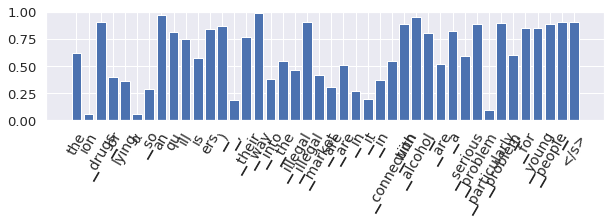

In [124]:
plt.figure(figsize=(10,2))

df_pred = pd.DataFrame(original_predictions.values, columns = ['probability'], index = predicted_sentence + ['</s>'])
#sns.set_style("white")
plt.bar(range(0,len(predicted_sentence + ['</s>'])), df_pred.probability, align='center')
plt.xticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14',rotation=60)
#plt.gca().invert_yaxis()
plt.grid(visible=True)
plt.ylim(0,1);

### ALTI of the entire model

In [125]:
total_rollout = hub.get_contribution_rollout(original_src_tensor, original_tgt_tensor, 'l1', norm_mode='min_sum')['total']
contributions_rollout_layer = total_rollout[-1]
source_total_alti = total_rollout[-1][:,:src_tensor.size(0)].detach().cpu().numpy()

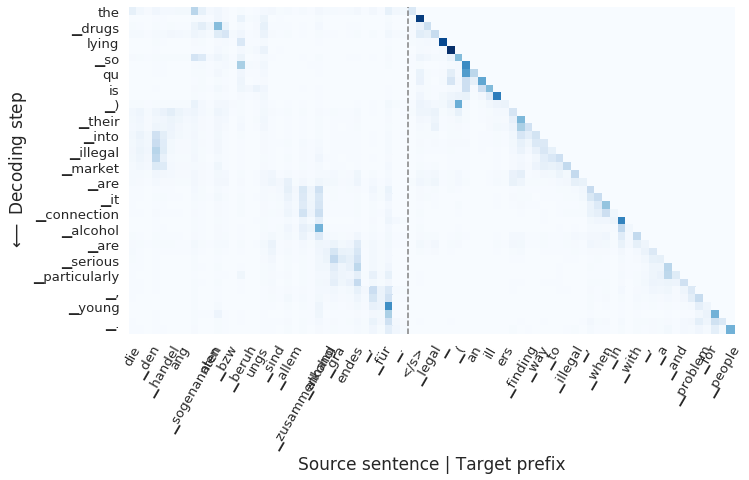

In [126]:
contributions_alti_layer_np = contributions_rollout_layer.detach().cpu().numpy()
plt.figure(figsize=(15,6))
df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Source sentence | Target prefix', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
plt.xticks(rotation=60);


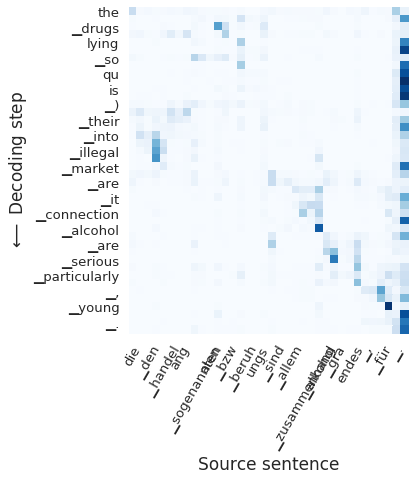

In [127]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(original_src_tensor, original_tgt_tensor, 'attn_w', norm_mode='sum_one')['decoder.encoder_attn'])

#cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6,6))

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['</s>'],index=predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel('Source sentence', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(rotation=60);

In [128]:
cross_attn_weights = torch.squeeze(hub.get_contributions(original_src_tensor, original_tgt_tensor, 'attn_w', norm_mode='sum_one')['decoder.encoder_attn'])
cross_attn_weights_layer = cross_attn_weights[4][:,:src_tensor.size(0)].detach().cpu().numpy()
cross_attn_weights_layer = cross_attn_weights_layer[:-1,:-1] # delete </s>
rank_cross_attn_weights_layer = rankdata(cross_attn_weights_layer, method='dense', axis = -1)
arg_max_weights = rank_cross_attn_weights_layer.argmax(axis=-1)

In [129]:
rank_cross_attn_weights_layer

array([[34, 17, 26, ..., 21, 10, 35],
       [20,  9, 12, ..., 14, 25, 34],
       [24, 16, 10, ...,  3, 15, 31],
       ...,
       [ 3,  2,  5, ..., 32, 35, 33],
       [ 1,  8,  2, ..., 26, 35, 34],
       [15,  7,  6, ..., 33, 34, 35]])

## Deletion progression

In [5]:
def prob_perturbation(hub, sample, method, plot=False):
    src_tensor = sample['src_tensor']
    original_src_tensor = src_tensor
    tgt_tensor = sample['tgt_tensor']
    original_tgt_tensor = src_tensor
    src_tok = sample['src_tok']
    tgt_tok = sample['tgt_tok']

    # Standard forward-pass
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    #print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    orig_pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
    probs = torch.nn.functional.softmax(log_probs, dim=-1)
    original_predictions = torch.max(probs,dim=-1)

    source_sentence = src_tok
    target_sentence = sample['tgt_tok']
    predicted_sentence = orig_pred_tok
    original_src_tensor = src_tensor
    original_tgt_tensor = tgt_tensor
    original_source_sentence = source_sentence
    original_target_sentence = target_sentence


    # Remove token
    prob_decay_pred = []
    #dec_step = 5
    for token_pos in range(len(original_source_sentence)):# + ['</s>']) + ['</s>'] + original_target_sentence)-1):
        predicted_sentence = orig_pred_tok
        if token_pos == len(original_source_sentence + ['</s>'])+1:
            pass
    #token_pos = 1
        if token_pos <= len(src_tok):
            tgt_tensor_del = original_tgt_tensor
            if method == 'deletion':
                src_tok_del = src_tok[:token_pos] + src_tok[token_pos+1:]
                src_tensor_del = torch.cat((src_tensor[:token_pos], src_tensor[token_pos+1:]))
                total_src = src_tok + ['</s>']
                tok_removed = total_src[token_pos]
            elif method == 'masking':
                src_tok_del = src_tok
                src_tensor_del = torch.cat((src_tensor[:token_pos],  torch.tensor(hub.task.source_dictionary.pad()).reshape(1), src_tensor[token_pos+1:]))
                total_src = src_tok + ['</s>']
                tok_removed = total_src[token_pos]

        else:
            token_pos_tgt = token_pos - (len(src_tok)+1)
            src_tensor_del = original_src_tensor
            if method == 'deletion':
                src_tok_del = src_tok
                tgt_tok_del = tgt_tok[:token_pos_tgt] + tgt_tok[token_pos_tgt+1:]
                tgt_tensor_del = torch.cat((original_tgt_tensor[:token_pos_tgt], original_tgt_tensor[token_pos_tgt+1:]))
                predicted_sentence = predicted_sentence[:token_pos_tgt] + predicted_sentence[token_pos_tgt+1:]
                total_tgt = ['</s>'] + tgt_tok#[token_pos]
                tok_removed = total_tgt[token_pos_tgt]
            elif method == 'masking':
                src_tok_del = src_tok
                tgt_tok_del = tgt_tok
                tgt_tensor_del = torch.cat((original_tgt_tensor[:token_pos_tgt],  torch.tensor(hub.task.target_dictionary.pad()).reshape(1), original_tgt_tensor[token_pos_tgt+1:]))
                total_tgt = ['</s>'] + tgt_tok#[token_pos]
                tok_removed = total_tgt[token_pos_tgt]

        model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor_del, tgt_tensor_del)
        pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
        pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
        pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
        #print(f"Predicted sentence: \t {pred_tok}")

        probs = torch.nn.functional.softmax(log_probs, dim=-1)

        source_sentence = src_tok_del
        target_sentence = tgt_tok
        #predicted_sentence = pred_tok

        if token_pos <= len(src_tok):
            deleted_pred = probs[:,original_predictions.indices].diag().detach()
        else:
            if method == 'deletion':
                pred_indices = torch.cat((original_predictions.indices[:token_pos_tgt], original_predictions.indices[token_pos_tgt+1:]))
            elif method == 'masking':
                pred_indices = original_predictions.indices
            deleted_pred = probs[:,pred_indices].diag()

        diff_prob = original_predictions.values.detach() - deleted_pred

        prob_decay_pred.append(diff_prob.tolist())

        if plot:

            plt.figure(figsize=(10,2))

            df_pred = pd.DataFrame(deleted_pred, columns = ['probability'], index = predicted_sentence + ['</s>'])
            #sns.set_style("white")
            plt.bar(range(0,len(predicted_sentence + ['</s>'])), df_pred.probability, align='center')
            plt.xticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14',rotation=60)
            plt.title('Deleted: ' + tok_removed)
            #plt.gca().invert_yaxis()
            plt.grid(visible=True)
            plt.ylim(0,1)

    # transpose, every sublist refers to predictions
    return list(map(list, zip(*prob_decay_pred)))

        # total_rollout = hub.get_contribution_rollout(src_tensor_del, tgt_tensor_del, 'l1', norm_mode='min_sum')['total']
        # contributions_rollout_layer = total_rollout[-1]
        # contributions_alti_layer_np = contributions_rollout_layer.detach().cpu().numpy()
        # plt.figure(figsize=(15,6),dpi=200)
        # df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
        # sns.set(font_scale=1.2)
        # s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
        # s.set_xlabel('Source sentence | Target prefix', fontsize=17)
        # s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
        # plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
        # plt.xticks(rotation=60);
    

In [8]:
#Ranking ALTI input attributions
from scipy.stats import rankdata
test_set_dir = europarl_dir / "processed_data/"
src = "de"
tgt = "en"
tokenizer = "bpe"
method = 'deletion' # 'deletion', 'masking'
attn_layer = 4
pred_decay_dict = defaultdict(list)

for i in range(0,30):
    print(i)
    #src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)
    sample = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)
    src_tensor = sample['src_tensor']
    original_src_tensor = src_tensor
    tgt_tensor = sample['tgt_tensor']
    original_tgt_tensor = tgt_tensor
    src_tok = sample['src_tok']

    # print(sample['src_word_sent'])
    # print(sample['tgt_word_sent'])

    
    prob_decay_pred = prob_perturbation(hub, sample, method, plot=False)

    total_rollout = hub.get_contribution_rollout(original_src_tensor, original_tgt_tensor, 'l1', norm_mode='min_sum')['total']
    source_total_alti = total_rollout[-1][:,:src_tensor.size(0)].detach().cpu().numpy()
    source_total_alti = source_total_alti[:-1,:-1] # delete </s>
    rank_total_alti = rankdata(source_total_alti, method='dense', axis = -1)
    #arg_max_alti = np.argmax(rank_total_alti,axis=-1)

    cross_attn_weights = torch.squeeze(hub.get_contributions(original_src_tensor, original_tgt_tensor, 'attn_w', norm_mode='sum_one')['decoder.encoder_attn'])
    cross_attn_weights_layer = cross_attn_weights[attn_layer][:,:src_tensor.size(0)].detach().cpu().numpy()
    cross_attn_weights_layer = cross_attn_weights_layer[:-1,:-1] # delete </s>
    rank_cross_attn_weights_layer = rankdata(cross_attn_weights_layer, method='dense', axis = -1)

    arg_max_alti = rank_total_alti.argmax(axis=-1)
    arg_max_weights = rank_cross_attn_weights_layer.argmax(axis=-1)
    
    for i, prediction in enumerate(prob_decay_pred[:-1]):
        pred_decay_dict['alti'].append(prob_decay_pred[i][arg_max_alti[i]])
        pred_decay_dict['attn_weights'].append(prob_decay_pred[i][arg_max_weights[i]])


0
Predicted sentence: 	 we do not believe that we should justerry @-@ pickick .
1
Predicted sentence: 	 that that is not true we !
2
Predicted sentence: 	 certainly course , if a drug addict becomes a druger , it it is right and necessary that he is be for be for the law . .
3
Predicted sentence: 	 mr , ladies and gentlemen , first would like to start by thanking mr burtone for his report .
4
Predicted sentence: 	 theion drugs orlyingα soanquillisers ) , their way into the illegal illegal market are are in it in connection with alcohol , are a serious problem particularly problem , for young people .
5
Predicted sentence: 	 allow would also to use advantage opportunity to thank my un to mr titley for
6
Predicted sentence: 	 the was therefore very difficult situation , i therefore welcome pleased with the new agreement .
7
Predicted sentence: 	 we must accept that there in the aream of blood and plasma donation , there systems are and are in a lines .
8
Predicted sentence: 	 the minutes

In [9]:
import statistics

print('Mean: ', statistics.mean(pred_decay_dict['alti']))
print('Std: ', statistics.stdev(pred_decay_dict['alti']))

print('Mean: ', statistics.mean(pred_decay_dict['attn_weights']))
print('Std: ', statistics.stdev(pred_decay_dict['attn_weights']))



Mean:  0.2924998722473075
Std:  0.359242899465104
Mean:  0.3220983416328884
Std:  0.35505635886953957


In [10]:
pred_decay_dict

defaultdict(list,
            {'alti': [0.46583640575408936,
              0.5155596733093262,
              0.0036186575889587402,
              0.39818891882896423,
              -0.03367149829864502,
              -0.06474608182907104,
              -0.08375990390777588,
              -0.1474049985408783,
              0.15212982892990112,
              0.017539143562316895,
              -0.25897538661956787,
              0.29236671328544617,
              0.22274121642112732,
              0.0038064122200012207,
              0.174726665019989,
              0.30002909898757935,
              0.17903846502304077,
              -0.16817861795425415,
              0.5905354022979736,
              0.08546659350395203,
              0.5001724362373352,
              0.28047844767570496,
              0.008424103260040283,
              0.015108764171600342,
              0.47609567642211914,
              0.15462404489517212,
              0.8739755153656006,
              0.8116196